In [1]:
import os
import sys

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from lib.dataset import EnvironmentalDataset
from lib.raster import PatchExtractor
from lib.utils import set_reproducibility

# For reproducibility
random_seed = 42
set_reproducibility(random_seed=random_seed)

# SETTINGS
# files
#DATASET_PATH = './data/full_dataset_KR.csv'
#RASTER_PATH = './data/rasters_KR/'

#DATASET_PATH = './data/Micromys minutus_멧밭쥐_GB,KR_no_redundancy.csv'
#RASTER_PATH = './data/rasters_KR/'

#DATASET_PATH = './data/Egretta garzetta_쇠백로_KR_no_redundancy.csv'
#RASTER_PATH = './data/rasters_KR/'

DATASET_PATH = './data/Halcyon pileata_청호반새_KR_no_redundancy.csv'
RASTER_PATH = './data/rasters_KR/'

#DATASET_PATH = './data/Aegithalos caudatus_오목눈이_KR_no_redundancy.csv'
#RASTER_PATH = './data/rasters_KR/'

# DATASET_PATH = './data/Emberiza cioides_멧새_KR_no_redundancy.csv'
# RASTER_PATH = './data/rasters_KR/'

#DATASET_PATH = './data/Hirundo rustica_제비_KR_no_redundancy.csv'
#RASTER_PATH = './data/rasters_KR/'

# DATASET_PATH = './data/Motacilla alba_알락할미새_KR_no_redundancy.csv'
# RASTER_PATH = './data/rasters_KR/'

# exclusion buffer
EXCLUSION_DIST = 10000 # exclusion distance
EXCLUSION_DIST2 = 0 # exclusion distance
LOCAL_CRS = 5181 # KR

# csv columns
#ID = 'id'
#LABEL = 'Label'
LATITUDE = 'decimalLatitude'
LONGITUDE = 'decimalLongitude'

# dataset construction
TEST_SIZE = 0.3
TRAIN_SIZE = 50 # integer or None

# environmental patches
PATCH_SIZE = 1

# model params
DROPOUT = 0
N_LABELS = 1 # probability of presence
SAVE_MODEL_PATH = './pretrained/001/sdm_dnn.pt'

In [3]:
# create patch extractor and add all default rasters
extractor = PatchExtractor(RASTER_PATH, size=PATCH_SIZE, verbose=True)
extractor.add_all(normalized=True, transform=None, ignore=['elevation'])

# READ DATASET
df = pd.read_csv(DATASET_PATH, header='infer', sep=',', low_memory=False)
# NOTE: 멧밭쥐 사용시 여기 수정 필요
#df = df[df['countryCode'] == 'KR']

# presence positions
p_pos = df[[LATITUDE, LONGITUDE]].to_numpy()

# remove redundant data
p_pos = extractor.remove_redundant_positions(raster_name='globcover', pos=p_pos)

# presence labels
p_labels = np.ones(len(p_pos), dtype=np.float32)

# splitting train and testset
train_p_pos, test_p_pos, train_p_labels, test_p_labels \
    = train_test_split(p_pos, p_labels, test_size=TEST_SIZE, train_size=TRAIN_SIZE, random_state=random_seed)

# To train presence/absence model, sampling pseudo-absence points from valid positions
# Valid positions are determined by a raster (study area) and presence positions
train_pa_pos = extractor.get_valid_positions(raster_name='bioclim_1', invalid_pos=train_p_pos, 
                                            sample_size=8000, drop_nodata=True,
                                            exclusion_dist=EXCLUSION_DIST, local_crs=LOCAL_CRS)
# under sampling to balance presence/absence samples
train_pa_pos = train_pa_pos[:len(train_p_pos)]

ex_pos = np.concatenate((train_p_pos, train_pa_pos, test_p_pos), axis=0)
#ex_pos = np.concatenate((train_p_pos, test_p_pos), axis=0)
test_pa_pos = extractor.get_valid_positions(raster_name='bioclim_1', invalid_pos=ex_pos, 
                                            sample_size=8000, drop_nodata=True,
                                            exclusion_dist=EXCLUSION_DIST2, local_crs=LOCAL_CRS)
test_pa_pos = test_pa_pos[:len(test_p_pos)]

# pseudo-absence pos, labels
train_pa_pos = train_pa_pos
train_pa_labels = np.zeros(len(train_pa_pos), dtype=np.float32)
test_pa_pos = test_pa_pos
test_pa_labels = np.zeros(len(test_pa_pos), dtype=np.float32)

# merge presences and pseudo-absences
train_pos = np.concatenate((train_p_pos, train_pa_pos), axis=0)
train_labels = np.concatenate((train_p_labels, train_pa_labels), axis=0)
train_ids = np.arange(len(train_pos))

test_pos = np.concatenate((test_p_pos, test_pa_pos), axis=0)
test_labels = np.concatenate((test_p_labels, test_pa_labels), axis=0)
test_ids = np.arange(len(test_pos))

# constructing pytorch dataset
train_set = EnvironmentalDataset(train_labels, train_pos, train_ids, patch_extractor=extractor)
test_set = EnvironmentalDataset(test_labels, test_pos, test_ids, patch_extractor=extractor)

# print sampled dataset
print('train_set presenses : ', len(train_set.labels[train_set.labels == 1]))
print('train_set pseudo-absences : ', len(train_set.labels[train_set.labels == 0]))

print('test_set presenses : ', len(test_set.labels[test_set.labels == 1]))
print('test_set pseudo-absences : ', len(test_set.labels[test_set.labels == 0]))

Adding ratser: bioclim_1  -4.4 24.7 -2.0

Adding ratser: bioclim_2  10.1 3.1 -1.0

Adding ratser: bioclim_3  34.4 18.7 14.278376

Adding ratser: bioclim_4  891.2 467.3 -2.0

Adding ratser: bioclim_5  13.8 21.7 -1.5

Adding ratser: bioclim_6  -20.4 26.0 -18.9

Adding ratser: bioclim_7  34.2 12.0 -1.0

Adding ratser: bioclim_8  -1.4 29.2 -2.0

Adding ratser: bioclim_9  -5.7 22.8 -11.3

Adding ratser: bioclim_10  6.9 21.2 -2.0

Adding ratser: bioclim_11  -14.4 26.8 -11.3

Adding ratser: bioclim_12  532.1 630.0 721.0

Adding ratser: bioclim_13  91.5 102.1 168.0

Adding ratser: bioclim_14  14.4 27.1 8.0

Adding ratser: bioclim_15  75.8 44.1 43.352425

Adding ratser: bioclim_16  235.7 274.3 393.0

Adding ratser: bioclim_17  52.3 90.5 39.0

Adding ratser: bioclim_18  152.6 183.3 137.0

Adding ratser: bioclim_19  104.1 181.2 39.0

Adding ratser: globcover  163.07932 61.9907 230

The number of environmental variables: 20
The size of a tensor/vector: 41

removed redundancies: 15, out of bounds: 

    labels                    geometry
0      1.0  POINT (126.98194 34.33750)
1      1.0  POINT (127.29028 35.08194)
2      1.0  POINT (127.45694 35.17361)
3      1.0  POINT (127.50694 37.76250)
4      1.0  POINT (126.64861 35.55694)
..     ...                         ...
95     0.0  POINT (126.82500 37.61667)
96     0.0  POINT (126.97500 35.80833)
97     0.0  POINT (126.92500 38.80000)
98     0.0  POINT (126.95833 35.62500)
99     0.0  POINT (127.17500 36.21667)

[100 rows x 2 columns]
EPSG:4326
     labels                    geometry
0       1.0  POINT (128.40694 37.80139)
1       1.0  POINT (127.97917 38.13472)
2       1.0  POINT (126.56250 35.23472)
3       1.0  POINT (127.20417 34.84861)
4       1.0  POINT (128.67083 36.82639)
..      ...                         ...
667     0.0  POINT (127.51667 35.54167)
668     0.0  POINT (125.77500 38.15000)
669     0.0  POINT (126.85000 35.38333)
670     0.0  POINT (128.05000 37.18333)
671     0.0  POINT (128.65833 36.51667)

[672 rows x 2 col

<AxesSubplot:title={'center':'testset'}>

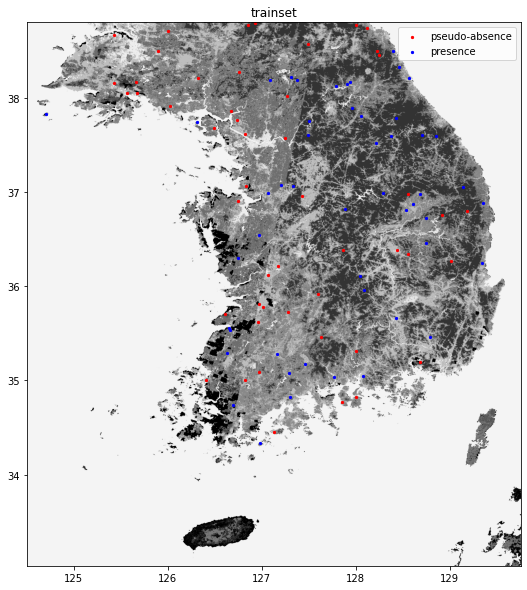

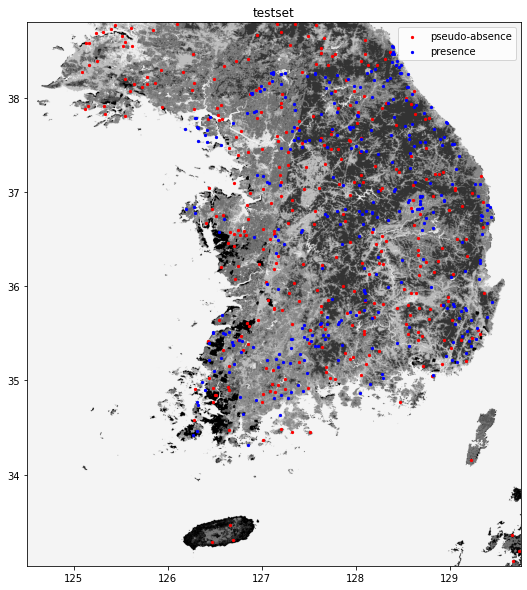

In [4]:
import rasterio
import rasterio.plot as rplt
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point

train_r = rasterio.open('./data/rasters_KR/globcover/globcover.tif')
test_r = rasterio.open('./data/rasters_KR/globcover/globcover.tif')

train_points = []
for (lat, long) in train_pos:
    train_points.append(Point(long, lat))
test_points = []
for (lat, long) in test_pos:
    test_points.append(Point(long, lat))

train_gdf = geopandas.GeoDataFrame({'labels': train_labels}, geometry=train_points, crs=train_r.crs)
test_gdf = geopandas.GeoDataFrame({'labels': test_labels}, geometry=test_points, crs=test_r.crs)

print(train_gdf)
print(train_r.crs)
print(test_gdf)
print(test_r.crs)

fig1, ax1 = plt.subplots(figsize=(10,10))
train_gdf[train_gdf['labels'] == 0].plot(ax=ax1, label='pseudo-absence', legend=True, markersize=5, color='red')
train_gdf[train_gdf['labels'] == 1].plot(ax=ax1, label='presence', legend=True, markersize=5, color='blue')
plt.title('trainset')
plt.legend()
rplt.show(train_r, ax=ax1, cmap='Greys_r')

fig2, ax2 = plt.subplots(figsize=(10,10))
test_gdf[test_gdf['labels'] == 0].plot(ax=ax2, label='pseudo-absence', legend=True, markersize=5, color='red')
test_gdf[test_gdf['labels'] == 1].plot(ax=ax2, label='presence', legend=True, markersize=5, color='blue')
plt.title('testset')
plt.legend()
rplt.show(test_r, ax=ax2, cmap='Greys_r')